# Continuous Control with DDPG

---

This notebook builds and trains a Deep Deterministic Policy Gradient (DDPG) agent locally to solve the Robotic Arm Continuous Control problem, using the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

First, we must build the required environment. The instructions to do so are shown here: https://github.com/udacity/deep-reinforcement-learning#dependencies

After setting up the environment, we begin by importing some necessary packages:

In [3]:
from collections import deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# DDPG agent to be trained
from DDPG.ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
print(env.brain_names)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

['ReacherBrain']


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

The next cell shows how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [7]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while False:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 4. Training the DDPG Agent

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [ ]:
agent = Agent(n_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=0)

In [8]:
def run_episode(agent, train_mode=False):
    """Runs a single episode of the environment.

    Params
    ======
        agent (Agent): agent object to be trained
        train_mode (bool): train_mode to be passed to the environment
    """  
    env_info = env.reset(train_mode=train_mode)[brain_name]# reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                        # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        if train_mode:
            agent.step(states, actions, rewards, next_states, dones)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    avg_score = np.mean(scores)
    return avg_score

In [9]:
def ddpg(agent, n_episodes=500, checkpoint_each=500, print_each=100,
         solve_window_size=100, solve_score=30):
    """Trains a DDPG agent.

    Params
    ======
        agent (Agent): agent object to be trained
        n_episodes (int): number of episodes
        checkpoint_each (int): number of episodes to skip before checkpointing model 
        print_each (int): number of episodes to skip before printing current score
        solve_window_size (int): number of consecutive episodes to consider the environment solved
        solve_score (int): minimum average score to reach after solve_window_size
    """
    scores = []
    scores_window = deque(maxlen=solve_window_size)
    for i in range(1, n_episodes+1):
        agent.reset()
        
        score = run_episode(agent, train_mode=True)
        scores.append(score)
        scores_window.append(score)
        
        avg_score = np.mean(scores_window)
        end = '\n' if (i%print_each == 0 or avg_score >= solve_score) else ''
        print("\rEpisode #{:3d}  |  "
              "Score: {:+6.2f}  |  "
              "Avg. Score: {:+6.2f}".format(i, score, avg_score),
              end=end
        )
        if i%checkpoint_each == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pt')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pt')
            print('Checkpoint saved!')
        if avg_score >= solve_score and i >= solve_window_size:
            print('Environment solved in {} episodes!'.format(i))
            break

    # save model after all episodes
    torch.save(agent.actor_local.state_dict(), 'model_actor.pt')
    torch.save(agent.critic_local.state_dict(), 'model_critic.pt')
    print('Model saved!')
    
    if np.mean(scores_window) < solve_score:
        print('Agent could not solve the environment in {} episodes'.format(n_episodes))
    
    return scores

In [11]:
all_scores = []
n_episodes = 500
print_each = 10
solve_score = 30
solve_window_size = 100

In [12]:
%%time
scores = ddpg(agent, n_episodes=n_episodes, print_each=print_each,
              solve_window_size=solve_window_size, solve_score=solve_score)
all_scores += scores

Episode # 10  |  Score:  +0.00  |  Avg. Score:  +0.93
Episode # 20  |  Score:  +1.47  |  Avg. Score:  +1.22
Episode # 30  |  Score:  +9.75  |  Avg. Score:  +2.21
Episode # 40  |  Score: +11.51  |  Avg. Score:  +3.04
Episode # 50  |  Score: +13.92  |  Avg. Score:  +4.09
Episode # 60  |  Score: +12.02  |  Avg. Score:  +5.12
Episode # 70  |  Score: +18.03  |  Avg. Score:  +5.55
Episode # 80  |  Score: +16.36  |  Avg. Score:  +6.40
Episode # 90  |  Score: +19.22  |  Avg. Score:  +7.40
Episode #100  |  Score:  +7.76  |  Avg. Score:  +7.96
Episode #110  |  Score: +17.82  |  Avg. Score:  +9.17
Episode #120  |  Score: +20.00  |  Avg. Score: +10.22
Episode #130  |  Score:  +4.66  |  Avg. Score: +11.11
Episode #140  |  Score: +14.93  |  Avg. Score: +12.18
Episode #150  |  Score: +20.01  |  Avg. Score: +12.45
Episode #160  |  Score:  +4.19  |  Avg. Score: +12.62
Episode #170  |  Score: +23.13  |  Avg. Score: +12.97
Episode #180  |  Score: +17.28  |  Avg. Score: +13.45
Episode #190  |  Score: +24.

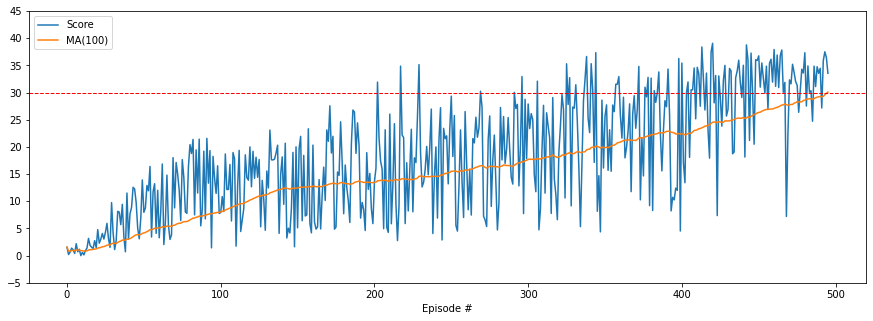

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(all_scores, label='Score')
pd.Series(all_scores).rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
ax.axhline(solve_score, ls='--', lw=1, c='red')
ax.set_xlabel('Episode #')
ax.set_yticks(list(set(list(plt.yticks()[0]) + [solve_score])))
ax.legend(loc='upper left');

### 5. Loading and executing DDPG Agent

As the model weights are saved, we can load them into a new agent.

In [ ]:
AGENT_TYPE = 'single_agent' if num_agents == 1 else 'multi_agent'
MODEL_FOLDER = f'./DDPG/models/{AGENT_TYPE}/'

In [14]:
trained_agent = Agent(n_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=0)
trained_agent.actor_local.load_state_dict(torch.load(MODEL_FOLDER + 'actor.pth'))
trained_agent.critic_local.load_state_dict(torch.load(MODEL_FOLDER + 'critic.pth'))

<All keys matched successfully>

In [15]:
run_episode(trained_agent)

35.81999919936061

When finished, you can close the environment.

In [16]:
env.close()